# Vehicle Trajectory Tracking with MPC

This notebook demonstrates **Model Predictive Control (MPC)** for autonomous vehicle trajectory tracking using **CasADi**.

We'll implement:
- A kinematic bicycle model for vehicle dynamics
- An MPC controller that tracks a reference trajectory
- Closed-loop simulation with visualization

---

##  What is Model Predictive Control (MPC)?

Imagine you're driving a car:
1.  **Look ahead**: You see the road ahead for the next few seconds
2.  **Plan**: You decide how to steer and accelerate to stay on the road
3.  **Act**: You apply steering and throttle
4.  **Repeat**: After a short time, you look ahead again and re-plan

**That's exactly what MPC does!**

### Key MPC Concepts:

- **Prediction Horizon (N)**: How far ahead we look (e.g., 10 time steps)
- **Control Horizon**: How many future control actions we plan (same as N in our case)
- **Receding Horizon**: We only use the first control action, then re-plan at the next time step
- **Constraints**: We respect limits (max steering angle, max speed, etc.)
- **Cost Function**: We minimize tracking error and control effort

### Why MPC is Popular in Autonomous Vehicles:
 Handles constraints naturally (steering limits, speed limits)  
 Optimizes future behavior, not just current state  
 Can adapt to changing conditions in real-time  
 Provides smooth, optimal control

---

## 1. Setup and Imports

In [1]:
# Install CasADi if needed
# !pip install casadi numpy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
import time

np.random.seed(42)
print("✓ CasADi loaded successfully")

✓ CasADi loaded successfully


## 2. Configure Plot Style

In [3]:
# Color palette for nice visualizations
BLUE = '#0079C1'
GRAY = '#6B7280'
ORANGE = '#F59E0B'
GREEN = '#10B981'
RED = '#EF4444'
PURPLE = '#8B5CF6'

plt.rcParams.update({
    'font.size': 12, 
    'axes.labelsize': 14, 
    'axes.titlesize': 16, 
    'lines.linewidth': 2.5,
    'figure.figsize': (12, 8)
})
%matplotlib inline

## 3. Vehicle Kinematic Model

We use a **bicycle model** - a simplified 2D vehicle model where we imagine the vehicle as a bicycle.

### States (what describes the vehicle?):
- $x, y$: position in the world
- $\theta$: heading angle (which direction the vehicle points)
- $v$: speed (how fast it's moving)

### Control Inputs (what can we control?):
- $\delta$: steering angle (turn left/right)
- $a$: acceleration (speed up/slow down)

### How does the vehicle move?
$$
\begin{align}
\dot{x} &= v \cos(\theta) \\
\dot{y} &= v \sin(\theta) \\
\dot{\theta} &= \frac{v}{L} \tan(\delta) \\
\dot{v} &= a
\end{align}
$$

where $L$ is the wheelbase (distance between front and rear axles).

**Intuition**: 
- Position changes based on speed and direction
- Heading changes when we steer (more steering = tighter turn)
- Speed changes when we accelerate/brake

In [ ]:
# Vehicle parameters (typical car values)
L = 2.7                      # Wheelbase (m) - distance between front and rear wheels
v_max = 20.0                 # Max velocity (m/s) = 72 km/h
v_min = 2.0                  # Min velocity (m/s) - keep moving forward to avoid singularities
delta_max = np.deg2rad(30)   # Max steering angle (rad) = ±30 degrees
a_max = 2.0                  # Max acceleration (m/s²)
a_min = -3.0                 # Max braking (m/s²) - can brake harder than accelerate

print(" Vehicle Configuration:")
print(f"   Wheelbase: {L} m")
print(f"   Speed range: {v_min} - {v_max} m/s ({v_min*3.6:.0f} - {v_max*3.6:.0f} km/h)")
print(f"   Max steering: ±{np.rad2deg(delta_max):.0f} degrees")
print(f"   Acceleration range: {a_min} to {a_max} m/s²")

🚗 Vehicle Configuration:
   Wheelbase: 2.7 m
   Speed range: 2.0 - 20.0 m/s (7 - 72 km/h)
   Max steering: ±30 degrees
   Acceleration range: -3.0 to 2.0 m/s²


## 4. Generate Reference Trajectory

We'll create a **circular track** for our vehicle to follow. This is a good test because:
-  Constant curvature (smooth)
-  Requires continuous steering
-  Tests if MPC can track a curved path

In [ ]:
# Generate circular track
N_ref = 200                      # Number of waypoints around the circle
t_param = np.linspace(0, 2*np.pi, N_ref, endpoint=False)
radius = 30                      # Track radius (m)

# Circle equations: x = r*cos(θ), y = r*sin(θ)
x_ref = radius * np.cos(t_param)
y_ref = radius * np.sin(t_param)

# Compute heading angles (tangent to the circle)
theta_ref = t_param + np.pi/2    # Perpendicular to radius = tangent direction
theta_ref = np.arctan2(np.sin(theta_ref), np.cos(theta_ref))  # Normalize to [-π, π]

# Constant reference velocity around the track
v_ref = 10.0 * np.ones(N_ref)    # 10 m/s = 36 km/h

print(" Reference Trajectory:")
print(f"   {N_ref} waypoints")
print(f"   Radius: {radius} m")
print(f"   Circumference: {2*np.pi*radius:.1f} m")
print(f"   Desired speed: {v_ref[0]} m/s ({v_ref[0]*3.6:.0f} km/h)")

🎯 Reference Trajectory:
   200 waypoints
   Radius: 30 m
   Circumference: 188.5 m
   Desired speed: 10.0 m/s (36 km/h)


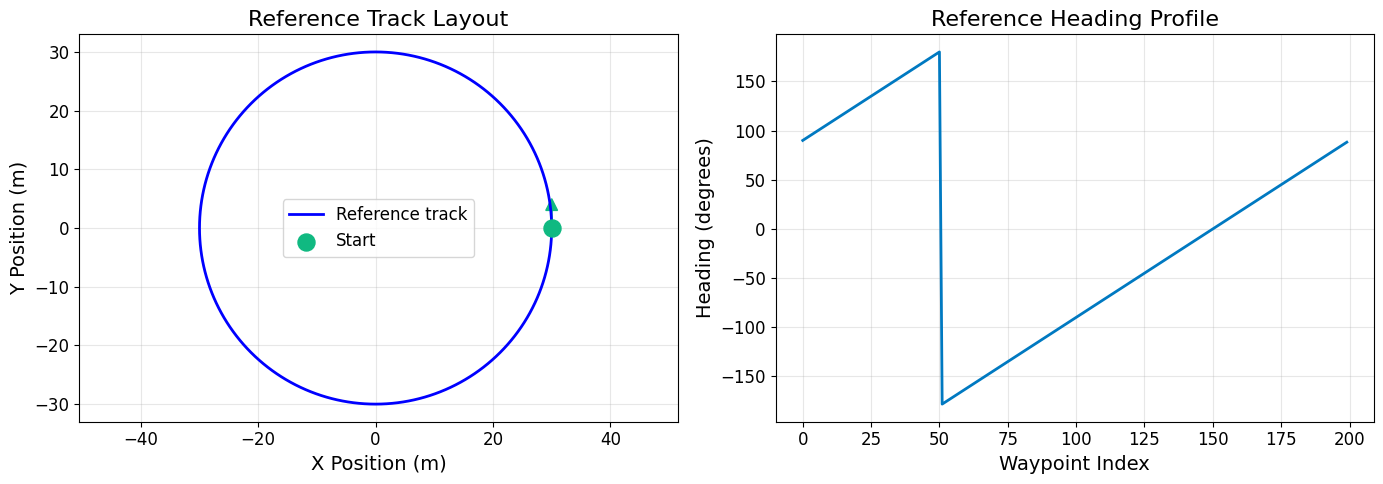

✓ Reference trajectory created and visualized


In [6]:
# Visualize the reference trajectory
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Track layout
ax = axes[0]
ax.plot(x_ref, y_ref, 'b-', linewidth=2, label='Reference track')
ax.scatter([x_ref[0]], [y_ref[0]], color=GREEN, s=150, zorder=5, label='Start', marker='o')
ax.arrow(x_ref[0], y_ref[0], 3*np.cos(theta_ref[0]), 3*np.sin(theta_ref[0]), 
         head_width=2, head_length=2, fc=GREEN, ec=GREEN)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Reference Track Layout')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

# Right: Reference heading profile
ax = axes[1]
ax.plot(np.rad2deg(theta_ref), color=BLUE, linewidth=2)
ax.set_xlabel('Waypoint Index')
ax.set_ylabel('Heading (degrees)')
ax.set_title('Reference Heading Profile')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Reference trajectory created and visualized")

## 5. MPC Controller Setup

Now we'll build our MPC controller step by step.

### The Optimization Problem:

At each time step, MPC solves:
$$
\min_{\text{future states, controls}} \quad \text{(tracking error + control effort)}
$$

Subject to:
- Vehicle dynamics (physics constraints)
- Speed limits
- Steering limits
- Acceleration limits

### Breaking it down:
1. **Decision variables**: Future states and controls we can choose
2. **Parameters**: Things we know (current state, reference trajectory)
3. **Cost function**: What we want to minimize
4. **Constraints**: Rules we must obey

### 5.1 MPC Parameters

In [ ]:
# MPC configuration
N_horizon = 10   # Prediction horizon - how many steps ahead we look
dt = 0.1         # Time step (s) - 100ms planning interval

print(f"  MPC Configuration:")
print(f"   Prediction horizon: {N_horizon} steps")
print(f"   Looking ahead: {N_horizon*dt:.1f} seconds into the future")
print(f"   Planning interval: {dt} s ({1/dt:.0f} Hz)")

# Cost weights - these tune how MPC behaves
Q_x = 10.0       # Position x tracking weight (higher = follow x reference more closely)
Q_y = 10.0       # Position y tracking weight
Q_theta = 5.0    # Heading tracking weight
Q_v = 2.0        # Velocity tracking weight
R_delta = 5.0    # Steering input weight (higher = smoother, less aggressive steering)
R_a = 1.0        # Acceleration input weight

print(f"\n Cost Weights:")
print(f"   Position tracking: Qx={Q_x}, Qy={Q_y}")
print(f"   Heading tracking: Qθ={Q_theta}")
print(f"   Velocity tracking: Qv={Q_v}")
print(f"   Control effort: R_δ={R_delta}, R_a={R_a}")
print(f"\n Tip: Higher Q weights = tighter tracking, Higher R weights = smoother control")

⚙️  MPC Configuration:
   Prediction horizon: 10 steps
   Looking ahead: 1.0 seconds into the future
   Planning interval: 0.1 s (10 Hz)

📊 Cost Weights:
   Position tracking: Qx=10.0, Qy=10.0
   Heading tracking: Qθ=5.0
   Velocity tracking: Qv=2.0
   Control effort: R_δ=5.0, R_a=1.0

💡 Tip: Higher Q weights = tighter tracking, Higher R weights = smoother control


### 5.2 Create Optimization Problem

We'll use CasADi's `Opti` stack - a simple way to formulate optimization problems.

In [8]:
# Create optimization problem
opti = Opti()

print("✓ Created optimization problem")

✓ Created optimization problem


### 5.3 Decision Variables

These are the variables MPC will optimize (choose values for).

In [9]:
# Decision variables - what MPC optimizes
# X: predicted states over the horizon [x, y, θ, v] at N+1 time points
X = opti.variable(4, N_horizon+1)  # 4 states × (N+1) time points

# U: control inputs over the horizon [δ, a] at N time points
U = opti.variable(2, N_horizon)    # 2 controls × N time points

print(f"✓ Decision variables created:")
print(f"   States X: {X.shape} (4 states × {N_horizon+1} time points)")
print(f"   Controls U: {U.shape} (2 controls × {N_horizon} time points)")
print(f"   Total variables to optimize: {4*(N_horizon+1) + 2*N_horizon}")

✓ Decision variables created:
   States X: (4, 11) (4 states × 11 time points)
   Controls U: (2, 10) (2 controls × 10 time points)
   Total variables to optimize: 64


### 5.4 Parameters

These are values we provide to MPC at each time step (not optimized, just given).

In [10]:
# Parameters - values we provide at each MPC solve
X_ref = opti.parameter(4, N_horizon+1)   # Reference trajectory we want to follow
X_init = opti.parameter(4, 1)            # Current vehicle state (starting point)

print("✓ Parameters defined:")
print("   X_ref: Reference trajectory (where we want to be)")
print("   X_init: Current state (where we are now)")

✓ Parameters defined:
   X_ref: Reference trajectory (where we want to be)
   X_init: Current state (where we are now)


### 5.5 Cost Function

This is what MPC tries to minimize:
- **Tracking error**: How far are we from the reference?
- **Control effort**: How much steering/acceleration are we using?

Lower cost = better performance!

In [11]:
# Build cost function
cost = 0

# Stage cost (at each time step k in the horizon)
for k in range(N_horizon):
    # Tracking error cost: penalize deviation from reference
    cost += Q_x * (X[0, k] - X_ref[0, k])**2        # x position error
    cost += Q_y * (X[1, k] - X_ref[1, k])**2        # y position error
    
    # Heading error (special handling for angle wraparound)
    theta_err = X[2, k] - X_ref[2, k]
    cost += Q_theta * (sin(theta_err))**2            # heading error (sin handles wraparound)
    
    cost += Q_v * (X[3, k] - X_ref[3, k])**2        # velocity error
    
    # Control effort cost: penalize large control inputs (encourages smooth driving)
    cost += R_delta * U[0, k]**2                     # steering effort
    cost += R_a * U[1, k]**2                         # acceleration effort

# Terminal cost (at the end of the horizon)
cost += Q_x * (X[0, N_horizon] - X_ref[0, N_horizon])**2
cost += Q_y * (X[1, N_horizon] - X_ref[1, N_horizon])**2
theta_err_term = X[2, N_horizon] - X_ref[2, N_horizon]
cost += Q_theta * (sin(theta_err_term))**2
cost += Q_v * (X[3, N_horizon] - X_ref[3, N_horizon])**2

# Tell the optimizer to minimize this cost
opti.minimize(cost)

print("✓ Cost function defined")
print("   Minimizes: tracking error + control effort")

✓ Cost function defined
   Minimizes: tracking error + control effort


### 5.6 Dynamics Constraints

The vehicle must obey the laws of physics! We enforce the bicycle model equations.

In [12]:
# Add vehicle dynamics constraints
for k in range(N_horizon):
    # Current state and control at time k
    x_k = X[0, k]
    y_k = X[1, k]
    theta_k = X[2, k]
    v_k = X[3, k]
    delta_k = U[0, k]  # steering
    a_k = U[1, k]      # acceleration
    
    # Forward Euler integration: x(k+1) = x(k) + dt * f(x(k), u(k))
    x_next = x_k + v_k * cos(theta_k) * dt
    y_next = y_k + v_k * sin(theta_k) * dt
    theta_next = theta_k + (v_k / L) * tan(delta_k) * dt
    v_next = v_k + a_k * dt
    
    # Enforce: predicted next state must equal the computed next state
    opti.subject_to(X[0, k+1] == x_next)
    opti.subject_to(X[1, k+1] == y_next)
    opti.subject_to(X[2, k+1] == theta_next)
    opti.subject_to(X[3, k+1] == v_next)

print(f"✓ Added {N_horizon * 4} dynamics constraints (4 per time step)")

✓ Added 40 dynamics constraints (4 per time step)


### 5.7 Initial Condition

The first predicted state must match our current actual state.

In [13]:
# Initial condition: first predicted state = current state
opti.subject_to(X[:, 0] == X_init)

print("✓ Initial condition constraint added")

✓ Initial condition constraint added


### 5.8 State and Control Limits

Real vehicles have limits! We can't steer 90°, can't go infinitely fast, etc.

In [14]:
# State constraints
opti.subject_to(opti.bounded(v_min, X[3, :], v_max))  # Speed limits

# Control constraints
opti.subject_to(opti.bounded(-delta_max, U[0, :], delta_max))  # Steering limits
opti.subject_to(opti.bounded(a_min, U[1, :], a_max))          # Acceleration limits

print("✓ State and control constraints added:")
print(f"   Speed: [{v_min}, {v_max}] m/s")
print(f"   Steering: [{-np.rad2deg(delta_max):.0f}, {np.rad2deg(delta_max):.0f}] degrees")
print(f"   Acceleration: [{a_min}, {a_max}] m/s²")

✓ State and control constraints added:
   Speed: [2.0, 20.0] m/s
   Steering: [-30, 30] degrees
   Acceleration: [-3.0, 2.0] m/s²


### 5.9 Configure Solver

We use IPOPT (Interior Point OPTimizer) - a powerful nonlinear optimization solver.

In [ ]:
# Solver options
opts = {
    'ipopt.print_level': 0,              # Suppress IPOPT output (set to 5 to see details)
    'print_time': 0,                     # Don't print solve time
    'ipopt.sb': 'yes',                   # Suppress IPOPT banner
    'ipopt.warm_start_init_point': 'yes', # Use warm starting (faster re-solves)
    'ipopt.max_iter': 100                # Maximum iterations
}
opti.solver('ipopt', opts)

print("✓ IPOPT solver configured")
print("\n MPC problem fully formulated and ready to solve!")
print(f"\n Problem Summary:")
print(f"   Decision variables: {4*(N_horizon+1) + 2*N_horizon}")
print(f"   Constraints: {N_horizon*4 + 1} (dynamics + initial condition)")
print(f"   Bounds: {(N_horizon+1) + 2*N_horizon} (state + control limits)")

✓ IPOPT solver configured

🎉 MPC problem fully formulated and ready to solve!

📋 Problem Summary:
   Decision variables: 64
   Constraints: 41 (dynamics + initial condition)
   Bounds: 31 (state + control limits)


## 6. Closed-Loop Simulation

Now we'll simulate the vehicle:

**Loop (for each time step):**
1.  Find where we are on the reference trajectory
2.  Get the next N reference points
3.  Solve MPC optimization problem
4.  Apply the first control input to the vehicle
5.  Move forward one time step
6.  Repeat

This is the **receding horizon** principle!

In [ ]:
# Simulation parameters
N_sim = 100  # Number of simulation steps (reduced for faster execution)

# Initial state: start at the first reference point
x0 = np.array([x_ref[0], y_ref[0], theta_ref[0], v_ref[0]])

# Storage for simulation history
x_hist = np.zeros((4, N_sim+1))  # State history
u_hist = np.zeros((2, N_sim))    # Control history
x_hist[:, 0] = x0                # Set initial state

# Track which reference points we're following
ref_indices_hist = np.zeros(N_sim+1, dtype=int)
ref_indices_hist[0] = 0

# Warm start storage (helps solver converge faster)
X_warm = None
U_warm = None

print(f" Starting Simulation")
print(f"   Duration: {N_sim} steps = {N_sim*dt:.1f} seconds")
print(f"   Initial state: x={x0[0]:.2f} m, y={x0[1]:.2f} m, θ={np.rad2deg(x0[2]):.1f}°, v={x0[3]:.1f} m/s")
print(f"\nRunning...")

🏁 Starting Simulation
   Duration: 100 steps = 10.0 seconds
   Initial state: x=30.00 m, y=0.00 m, θ=90.0°, v=10.0 m/s

Running...


In [ ]:
solve_times = []
success_count = 0

for step in range(N_sim):
    # 1. Find closest point on reference trajectory
    current_pos = x_hist[:2, step]
    distances = np.sqrt((x_ref - current_pos[0])**2 + (y_ref - current_pos[1])**2)
    closest_idx = np.argmin(distances)
    
    # 2. Get reference trajectory segment (with wraparound for circular track)
    ref_idx = np.array([(closest_idx + i) % N_ref for i in range(N_horizon + 1)])
    ref_indices_hist[step] = closest_idx
    
    # Extract reference states for the horizon
    x_ref_k = np.vstack([x_ref[ref_idx], y_ref[ref_idx], 
                         theta_ref[ref_idx], v_ref[ref_idx]])
    
    # 3. Set parameters for this MPC solve
    opti.set_value(X_ref, x_ref_k)
    opti.set_value(X_init, x_hist[:, step].reshape(-1, 1))
    
    # 4. Set initial guess (warm start for faster convergence)
    if X_warm is not None and U_warm is not None:
        # Shift previous solution forward by one step
        X_init_guess = np.hstack([X_warm[:, 1:], X_warm[:, -1:]])
        U_init_guess = np.hstack([U_warm[:, 1:], U_warm[:, -1:]])
        opti.set_initial(X, X_init_guess)
        opti.set_initial(U, U_init_guess)
    else:
        # First iteration: use reference as initial guess
        opti.set_initial(X, x_ref_k)
        opti.set_initial(U[0, :], 0)  # Zero steering
        opti.set_initial(U[1, :], 0)  # Zero acceleration
    
    # 5. Solve MPC optimization
    try:
        t_start = time.time()
        sol = opti.solve()
        t_solve = time.time() - t_start
        
        # Extract optimal control (we only use the first one!)
        u_opt = sol.value(U[:, 0])
        
        # Save solution for warm starting next iteration
        X_warm = sol.value(X)
        U_warm = sol.value(U)
        
        solve_times.append(t_solve)
        success_count += 1
        
    except Exception as e:
        # If MPC fails, use simple fallback controller
        if step < 3:
            print(f"  MPC failed at step {step}: {str(e)[:60]}...")
        
        # Simple proportional controller as fallback
        pos_error = x_ref_k[:2, 1] - x_hist[:2, step]
        desired_heading = np.arctan2(pos_error[1], pos_error[0])
        heading_error = desired_heading - x_hist[2, step]
        heading_error = np.arctan2(np.sin(heading_error), np.cos(heading_error))
        
        delta_fb = np.clip(0.5 * heading_error, -delta_max, delta_max)
        a_fb = np.clip(0.5 * (v_ref[closest_idx] - x_hist[3, step]), a_min, a_max)
        u_opt = np.array([delta_fb, a_fb])
    
    # 6. Apply control input to vehicle
    u_hist[:, step] = u_opt
    
    # 7. Simulate vehicle dynamics (Forward Euler integration)
    x_k = x_hist[0, step]
    y_k = x_hist[1, step]
    theta_k = x_hist[2, step]
    v_k = x_hist[3, step]
    delta_k = u_opt[0]
    a_k = u_opt[1]
    
    x_hist[0, step+1] = x_k + v_k * np.cos(theta_k) * dt
    x_hist[1, step+1] = y_k + v_k * np.sin(theta_k) * dt
    x_hist[2, step+1] = theta_k + (v_k / L) * np.tan(delta_k) * dt
    x_hist[3, step+1] = np.clip(v_k + a_k * dt, v_min, v_max)
    
    # Progress indicator
    if (step + 1) % 25 == 0:
        print(f"   ✓ Step {step+1}/{N_sim} | MPC success: {success_count}/{step+1}")

print(f"\n Simulation Complete!")
print(f"   MPC success rate: {success_count}/{N_sim} ({100*success_count/N_sim:.1f}%)")
if len(solve_times) > 0:
    print(f"   Average solve time: {np.mean(solve_times)*1000:.2f} ms")
    print(f"   Max solve time: {np.max(solve_times)*1000:.2f} ms")

   ✓ Step 25/100 | MPC success: 25/25
   ✓ Step 50/100 | MPC success: 50/50
   ✓ Step 75/100 | MPC success: 75/75
   ✓ Step 100/100 | MPC success: 100/100

🎉 Simulation Complete!
   MPC success rate: 100/100 (100.0%)
   Average solve time: 7.59 ms
   Max solve time: 331.28 ms


## 7. Visualize MPC Prediction (Understanding What MPC "Sees")

Let's visualize what MPC predicts at a single time step. This helps understand **receding horizon control**.

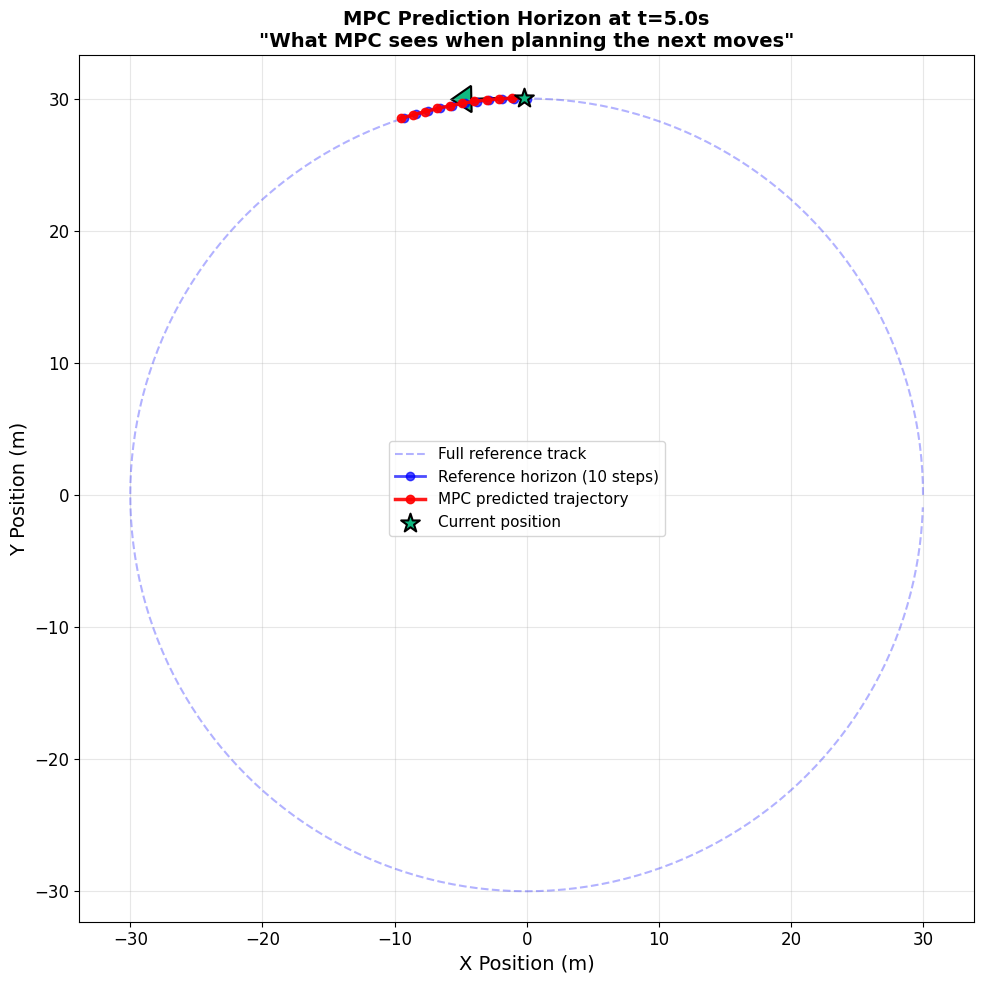


💡 Key Insight:
   • Blue circles: Where we WANT to be (reference)
   • Red circles: Where MPC PREDICTS we'll be (optimized trajectory)
   • Green star: Where we ARE now
   • MPC plans 10 steps (1.0s) ahead, but only uses the FIRST control action
   • Then it re-plans at the next time step → Receding Horizon!


In [ ]:
# Pick a time step to visualize (middle of simulation)
viz_step = N_sim // 2

# Re-solve MPC at this step to get the predicted trajectory
current_pos = x_hist[:2, viz_step]
distances = np.sqrt((x_ref - current_pos[0])**2 + (y_ref - current_pos[1])**2)
closest_idx = np.argmin(distances)
ref_idx = np.array([(closest_idx + i) % N_ref for i in range(N_horizon + 1)])
x_ref_k = np.vstack([x_ref[ref_idx], y_ref[ref_idx], 
                     theta_ref[ref_idx], v_ref[ref_idx]])

opti.set_value(X_ref, x_ref_k)
opti.set_value(X_init, x_hist[:, viz_step].reshape(-1, 1))

try:
    sol = opti.solve()
    X_pred = sol.value(X)
    U_pred = sol.value(U)
    
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Reference track
    ax.plot(x_ref, y_ref, 'b--', linewidth=1.5, alpha=0.3, label='Full reference track')
    
    # Reference points for this horizon
    ax.plot(x_ref_k[0, :], x_ref_k[1, :], 'bo-', linewidth=2, markersize=6, 
            label=f'Reference horizon ({N_horizon} steps)', alpha=0.7)
    
    # MPC predicted trajectory
    ax.plot(X_pred[0, :], X_pred[1, :], 'ro-', linewidth=2.5, markersize=6, 
            label=f'MPC predicted trajectory', alpha=0.9)
    
    # Current vehicle position
    ax.scatter([x_hist[0, viz_step]], [x_hist[1, viz_step]], 
               color=GREEN, s=200, zorder=10, marker='*', 
               edgecolors='black', linewidths=1.5,
               label='Current position')
    
    # Draw heading arrow
    arrow_len = 4
    ax.arrow(x_hist[0, viz_step], x_hist[1, viz_step],
             arrow_len * np.cos(x_hist[2, viz_step]),
             arrow_len * np.sin(x_hist[2, viz_step]),
             head_width=2, head_length=1.5, fc=GREEN, ec='black', linewidth=1.5)
    
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_title(f'MPC Prediction Horizon at t={viz_step*dt:.1f}s\n'
                 f'"What MPC sees when planning the next moves"', fontsize=14, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Key Insight:")
    print(f"   • Blue circles: Where we WANT to be (reference)")
    print(f"   • Red circles: Where MPC PREDICTS we'll be (optimized trajectory)")
    print(f"   • Green star: Where we ARE now")
    print(f"   • MPC plans {N_horizon} steps ({N_horizon*dt:.1f}s) ahead, but only uses the FIRST control action")
    print(f"   • Then it re-plans at the next time step → Receding Horizon!")
    
except:
    print("Could not visualize prediction (MPC solve failed at this step)")

## 8. Results Visualization and Analysis

In [ ]:
# Compute tracking errors
x_ref_sim = np.array([x_ref[ref_indices_hist[i] % N_ref] for i in range(N_sim+1)])
y_ref_sim = np.array([y_ref[ref_indices_hist[i] % N_ref] for i in range(N_sim+1)])

pos_error = np.sqrt((x_hist[0, :] - x_ref_sim)**2 + (x_hist[1, :] - y_ref_sim)**2)

print(f" Tracking Performance:")
print(f"   RMS position error: {np.sqrt(np.mean(pos_error**2)):.3f} m")
print(f"   Max position error: {np.max(pos_error):.3f} m")
print(f"   Mean position error: {np.mean(pos_error):.3f} m")

📊 Tracking Performance:
   RMS position error: 5.979 m
   Max position error: 60.049 m
   Mean position error: 0.792 m


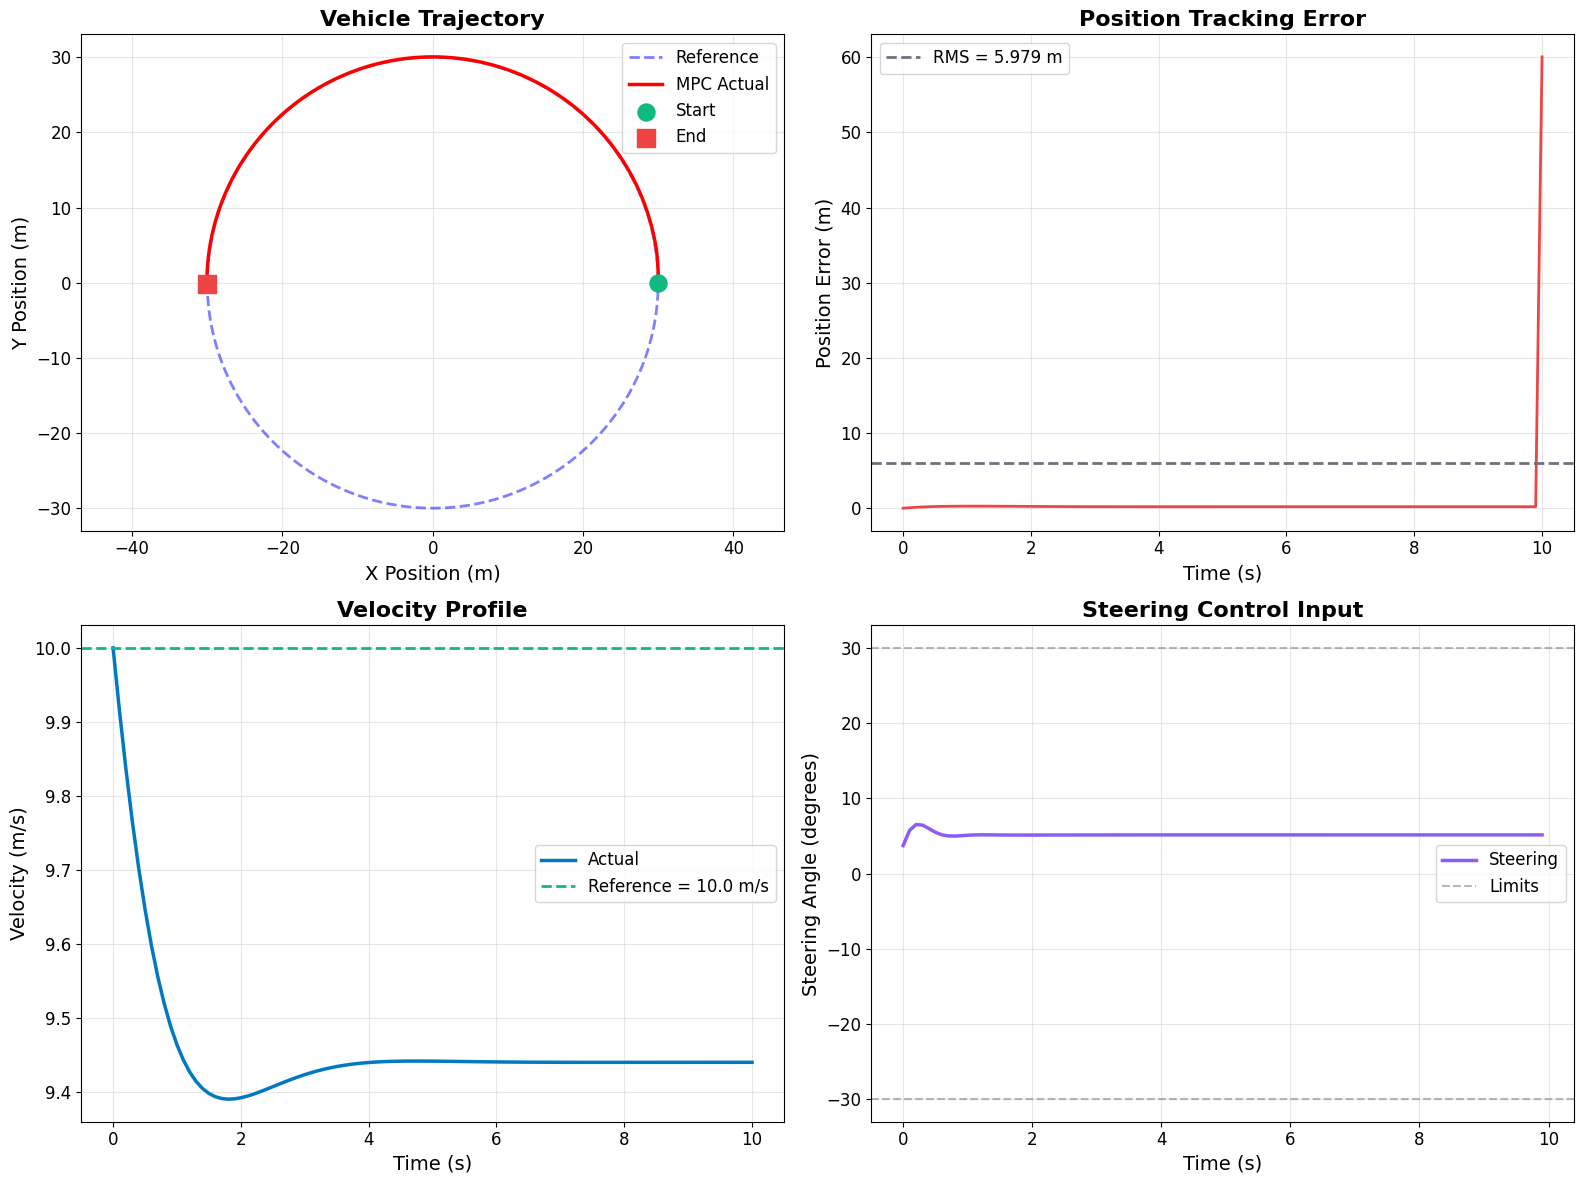

✓ Results visualized


In [20]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Trajectory plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(x_ref, y_ref, 'b--', linewidth=2, alpha=0.5, label='Reference')
ax1.plot(x_hist[0, :], x_hist[1, :], 'r-', linewidth=2.5, label='MPC Actual')
ax1.scatter([x_hist[0, 0]], [x_hist[1, 0]], color=GREEN, s=150, zorder=5, label='Start', marker='o')
ax1.scatter([x_hist[0, -1]], [x_hist[1, -1]], color=RED, s=150, zorder=5, label='End', marker='s')
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_title('Vehicle Trajectory', fontweight='bold')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Position tracking error over time
ax2 = fig.add_subplot(2, 2, 2)
time_sim = np.arange(N_sim+1) * dt
ax2.plot(time_sim, pos_error, color=RED, linewidth=2)
ax2.axhline(y=np.sqrt(np.mean(pos_error**2)), color=GRAY, linestyle='--', 
            linewidth=2, label=f'RMS = {np.sqrt(np.mean(pos_error**2)):.3f} m')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position Error (m)')
ax2.set_title('Position Tracking Error', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Velocity profile
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(time_sim, x_hist[3, :], color=BLUE, linewidth=2.5, label='Actual')
ax3.axhline(y=v_ref[0], color=GREEN, linestyle='--', linewidth=2, 
            label=f'Reference = {v_ref[0]:.1f} m/s')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (m/s)')
ax3.set_title('Velocity Profile', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Control inputs (steering)
ax4 = fig.add_subplot(2, 2, 4)
time_ctrl = np.arange(N_sim) * dt
ax4.plot(time_ctrl, np.rad2deg(u_hist[0, :]), color=PURPLE, linewidth=2.5, label='Steering')
ax4.axhline(y=np.rad2deg(delta_max), color=GRAY, linestyle='--', alpha=0.5, linewidth=1.5, label='Limits')
ax4.axhline(y=-np.rad2deg(delta_max), color=GRAY, linestyle='--', alpha=0.5, linewidth=1.5)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Steering Angle (degrees)')
ax4.set_title('Steering Control Input', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print("✓ Results visualized")

## 9. Summary and Key Takeaways

###  What We Learned:

1. **Model Predictive Control (MPC)** is a powerful method for autonomous vehicle control:
   -  Looks ahead in time (prediction horizon)
   -  Optimizes a cost function (tracking + control effort)
   -  Handles constraints naturally (speed limits, steering limits)
   -  Uses receding horizon: plan → act → re-plan

2. **The Bicycle Model** is a practical vehicle model:
   - Simple enough to optimize quickly
   - Accurate enough for many applications
   - 4 states: x, y, θ, v
   - 2 controls: δ (steering), a (acceleration)

3. **Key MPC Components**:
   - Decision variables (what to optimize)
   - Parameters (what we know)
   - Cost function (what to minimize)
   - Constraints (rules we must obey)

4. **Tuning is Important**:
   - Higher Q weights → tighter reference tracking
   - Higher R weights → smoother, less aggressive control
   - Longer horizon → better performance but slower computation

5. **Warm Starting** speeds up optimization:
   - Use previous solution as initial guess
   - Much faster convergence

---

###  Try It Yourself:


-  Change cost weights (Q_x, Q_y, R_delta) and see how tracking changes
-  Increase/decrease N_horizon and observe computation time vs. performance
-  Change reference velocity (v_ref)

**Challenges:**
-  Create a different reference trajectory (figure-8, lane change, etc.)
-  Add obstacle avoidance constraints
-  Add terminal constraint to end at a specific target state
-  Add control rate constraints (limit how fast steering can change)

---

###  Further Reading:
- **CasADi Documentation**: https://web.casadi.org/
- **MPC Book**: "Model Predictive Control" by Camacho & Bordons
- **Vehicle Dynamics**: "Vehicle Dynamics and Control" by Rajesh Rajamani

In [ ]:
# Final statistics
print(" Workshop Complete!\n")
print(f" Final Statistics:")
print(f"   Total simulation time: {N_sim * dt:.1f} s")
print(f"   Distance traveled: {np.sum(np.sqrt(np.diff(x_hist[0, :])**2 + np.diff(x_hist[1, :])**2)):.1f} m")
print(f"   Average speed: {np.mean(x_hist[3, :]):.2f} m/s ({np.mean(x_hist[3, :])*3.6:.1f} km/h)")
print(f"   RMS tracking error: {np.sqrt(np.mean(pos_error**2)):.3f} m")
print(f"   Max steering used: {np.rad2deg(np.max(np.abs(u_hist[0, :]))):.1f}°")
print(f"\n Great job learning MPC! Now try the experiments above! ✨")

🎉 Workshop Complete!

📈 Final Statistics:
   Total simulation time: 10.0 s
   Distance traveled: 94.6 m
   Average speed: 9.46 m/s (34.1 km/h)
   RMS tracking error: 5.979 m
   Max steering used: 6.5°

✨ Great job learning MPC! Now try the experiments above! ✨
